In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import pandas as pd
import numpy as np
import iris

from utils import get_aeronet_data, get_bc_ppe_data
from GCEm import gp_model
from GCEm.sampler import MCMCSampler

import os

import matplotlib.pyplot as plt
%matplotlib inline

# GPU = "1"

# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Read in the parameters and observables

In [3]:
ppe_params, ppe_aaod = get_bc_ppe_data()

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


In [4]:
# Calculate the global, annual mean AAOD (CIS will automatically apply the weights)
mean_aaod, = ppe_aaod.collapsed(['latitude', 'longitude', 'time'], 'mean')

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


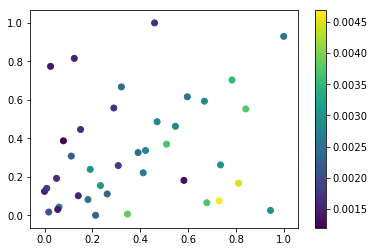

In [5]:
plt.scatter(ppe_params.BCnumber, ppe_params.Wetdep, c=mean_aaod.data)
plt.colorbar()

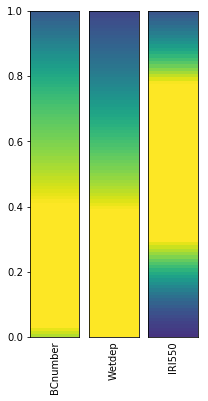

In [6]:
from GCEm.utils import plot_parameter_space

plot_parameter_space(ppe_params, fig_size=(3,6))

In [7]:
n_test = 8

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = mean_aaod[:n_test], mean_aaod[n_test:]

# Setup and run the models

In [8]:
model = gp_model(X_train, Y_train)

In [9]:
model.train()

In [10]:
m, v = model.predict(X_test.values)

Proportion of 'Bad' estimates : 0.00%


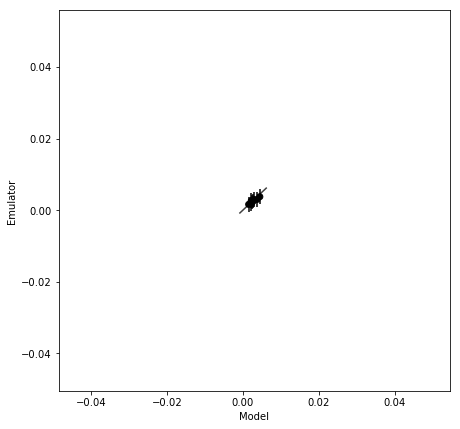

In [11]:
from GCEm.utils import validation_plot

validation_plot(Y_test.data.flatten(), m.data.flatten(), v.data.flatten())


In [12]:
# Set the objective as one of the test datasets
sampler = MCMCSampler(model, Y_test[0])

In [13]:
samples = sampler.sample(n_samples=2000)

Acceptance rate: 0.9164877791764674


In [14]:
new_samples = pd.DataFrame(data=samples, columns=ppe_params.columns)
m, _ = model.predict(new_samples.values)
Zs = m.data

In [15]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

Sample mean: 0.0028079677209622246
Sample std dev: 0.0007865571705425585


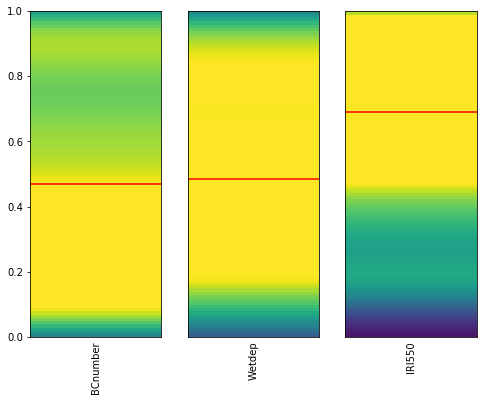

In [16]:
plot_parameter_space(new_samples, target_df=X_test.iloc[0])

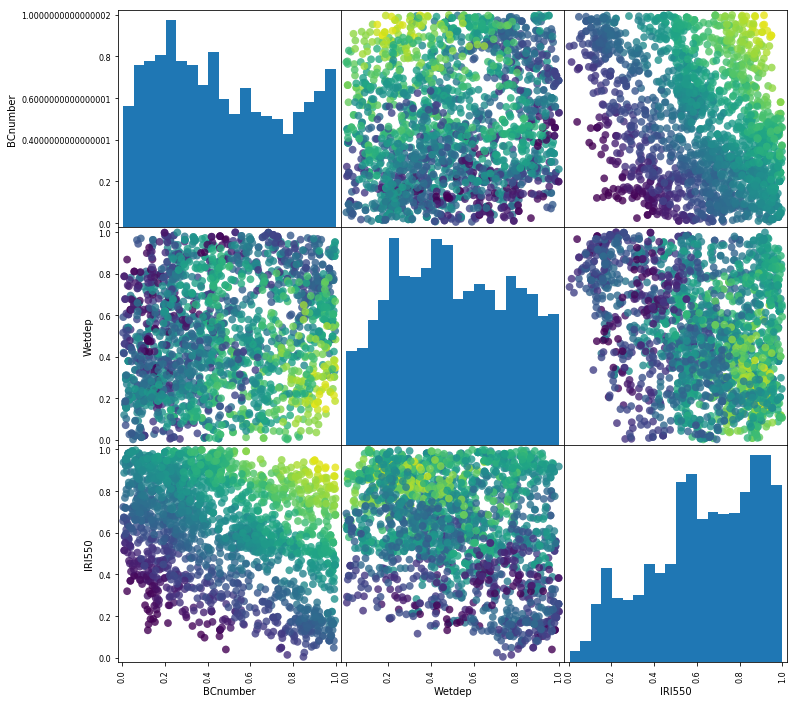

In [17]:
grr = pd.plotting.scatter_matrix(new_samples, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)

In [18]:
from GCEm.abc_sampler import ABCSampler, constrain
from GCEm.utils import get_random_params

In [19]:
sampler = ABCSampler(model, Y_test[0])

samples = sampler.sample(n_samples=2000, threshold=0.5)
valid_points = pd.DataFrame(data=samples, columns=ppe_params.columns)

Acceptance rate: 0.34417484081913613


In [20]:
m, _ = model.predict(valid_points.values)
Zs = m.data

In [21]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

Sample mean: 0.002821301902590726
Sample std dev: 0.000299941494742838


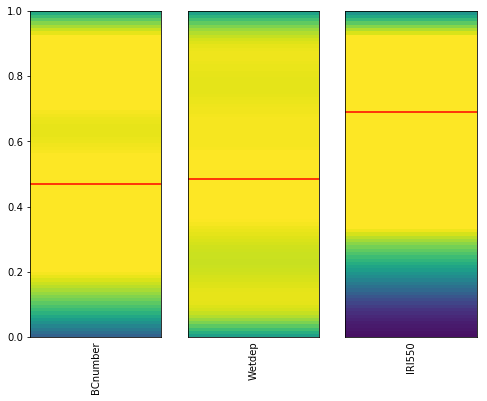

In [22]:
plot_parameter_space(valid_points, target_df=X_test.iloc[0])

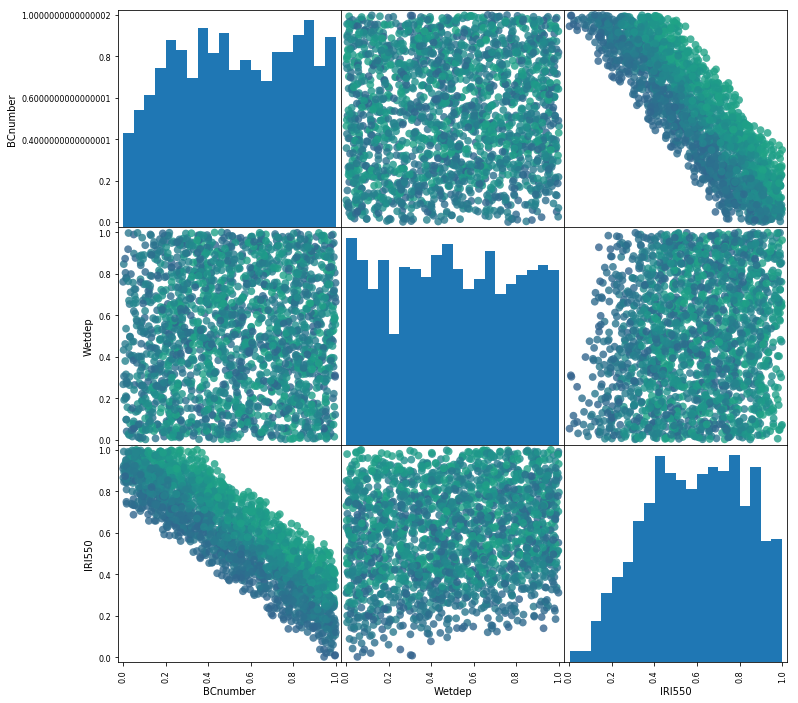

In [23]:
grr = pd.plotting.scatter_matrix(valid_points, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)